In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_queryfunction.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_queryfunctiontest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 10].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 10].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.010878,0.011822,0.0,68812.800000,0.011849,1277.400000,11126.022222,1.0,1.0,3.108310,6.0,8.838889,2.508814e+10,19.303509
1,0.271863,0.012267,0.0,68266.666667,0.110459,2823.755556,13758.377778,1.0,1.0,3.108310,6.0,10.050000,2.508814e+10,19.035886
2,0.390756,0.011378,0.0,67538.488889,0.110459,2926.911111,13590.200000,1.0,2.0,2.906795,6.0,10.050000,2.508814e+10,19.035886
3,0.029339,0.011378,0.0,64898.844444,0.017834,4493.800000,15952.066667,1.0,3.0,2.870390,6.0,9.944444,2.508814e+10,19.041102
4,0.029339,0.011111,0.0,65080.888889,0.017834,3251.511111,14077.755556,1.0,3.0,3.104242,6.0,9.944444,2.508814e+10,19.041102


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,0.355323,484.289126,3.108310,1.0
1,0.404010,477.574963,3.108310,1.0
2,0.404010,477.574963,2.906795,2.0
3,0.399767,477.705830,2.870390,3.0
4,0.399767,477.705830,3.104242,3.0


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
2418,3.399445,783.428198,5.390948,100.0
2419,3.399445,783.428198,5.474814,108.0
2423,3.516486,736.473293,5.517585,95.0
2424,3.531347,743.893402,5.517585,109.0
2425,3.531347,743.893402,9.078243,110.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(1114, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

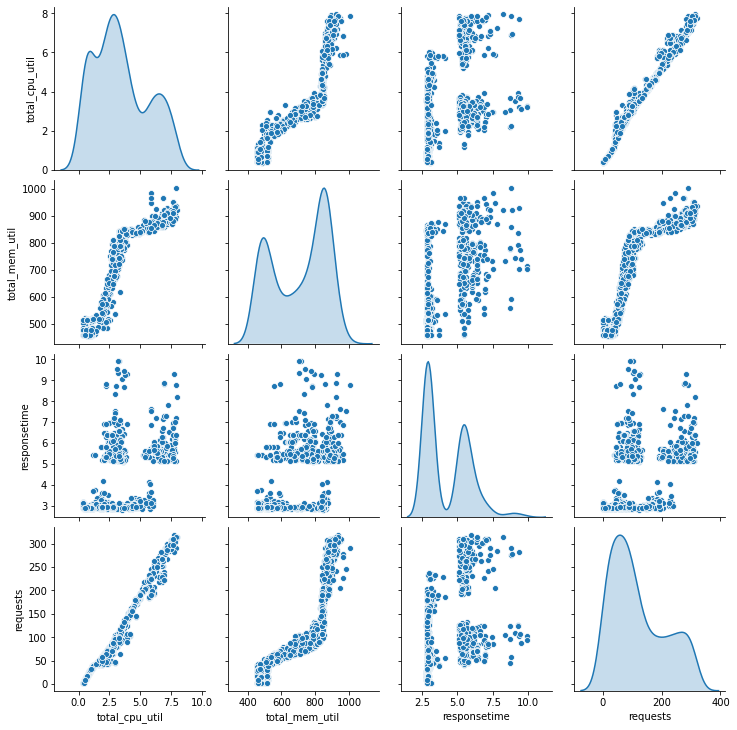

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,891.0,3.450790,2.159684,0.355323,1.861970,3.096253,5.052066,7.955133
total_mem_util,891.0,708.164499,161.494469,453.932851,525.112320,754.811290,848.526950,1003.833139
responsetime,891.0,4.298160,1.570834,2.790785,2.908759,3.149159,5.520318,9.907126
requests,891.0,120.112233,91.108460,1.000000,46.000000,93.000000,188.500000,319.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
2311,0.390610,458.362675,3.149159,1.0
2418,3.399445,783.428198,5.390948,100.0
411,1.760760,512.128819,2.964121,54.0
2063,6.621387,860.718490,5.604232,218.0
1439,1.143243,518.734848,2.863914,39.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss']+history.history['val_loss'])+100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

In [17]:
def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


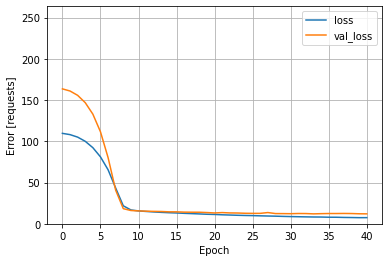

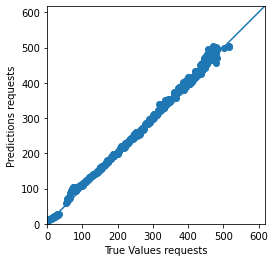

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


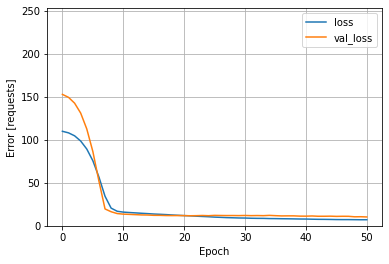

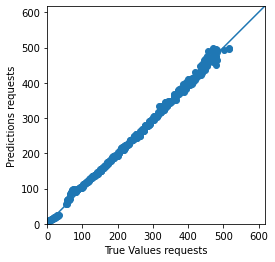

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


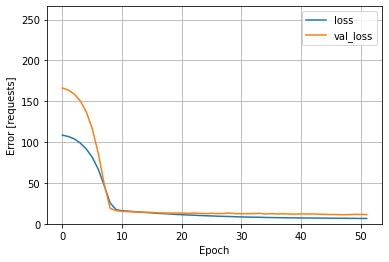

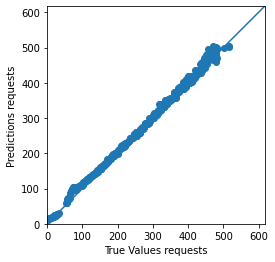

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


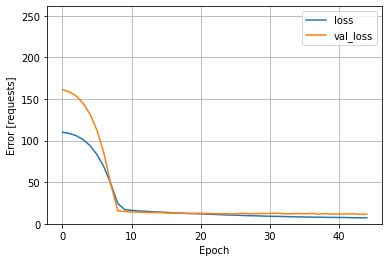

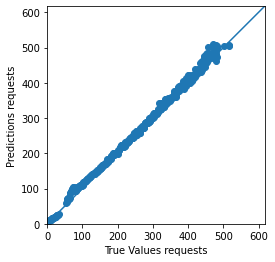

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


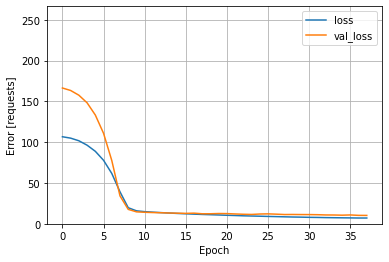

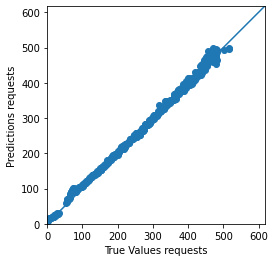

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_one (Dense)            (None, 64)                256       
_________________________________________________________________
dense_two (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_three (Dense)          (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________
None


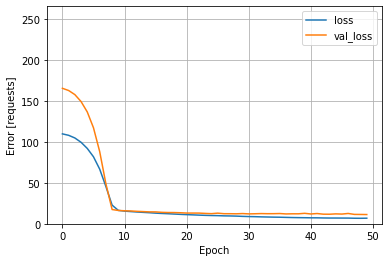

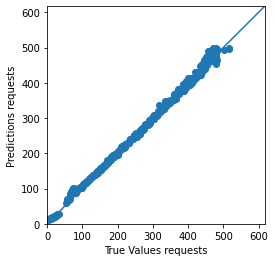

In [19]:
#%%time
i = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    dnn_model = None
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    plot_loss(history)
    loss.append(dnn_model.evaluate(val_features, val_labels,verbose=0))
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()

    plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

In [20]:
data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

,model,loss,score
0,dnn_model_0,7.604164123535156,99.54200456850464
1,dnn_model_1,6.810604572296143,99.68235289931663
2,dnn_model_2,7.640241622924805,99.48402826456262
3,dnn_model_3,7.416594505310059,99.38348910972046
4,dnn_model_4,9.832172393798828,99.65874664665678
5,dnn_model_5,7.818257808685303,99.67704361375088


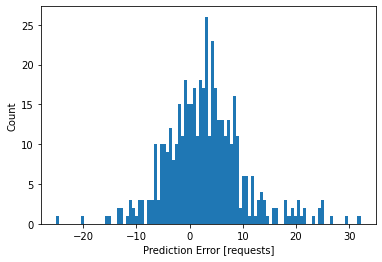

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')